In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats
import math
%matplotlib inline

ImportError: cannot import name 'bootstrap'

In [ ]:
plt.rcParams["figure.figsize"] = (12,6) # set figure size

## Coris data analysis
It is well known that LDL (low density lipoprotein) is a bad cholesterol which increases the risk of coronary heart diseases (CHD). From the coris data analysis, we can show it. First we read the data and get summary statistics.

In [23]:
df = pd.read_csv('coris.txt', sep=',', skiprows=[0, 1])
df.head(2)

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1


In [24]:
df['chd'] = df['chd'].astype('category')
df['chd'].value_counts()

0    302
1    160
Name: chd, dtype: int64

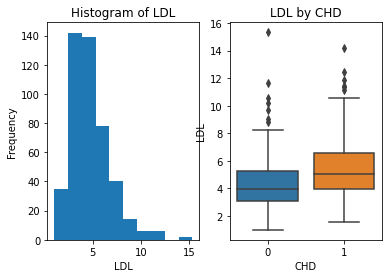

In [25]:
plt.subplot(1, 2, 1)
plt.hist(df['ldl'])
plt.xlabel('LDL')
plt.ylabel('Frequency')
plt.title('Histogram of LDL')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='chd', y='ldl')
plt.xlabel('CHD')
plt.ylabel('LDL')
plt.title('LDL by CHD');

### Get a little bit fancier plots using seaborn.

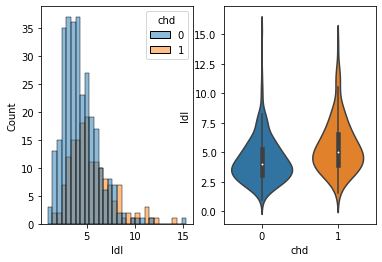

In [26]:
plt.subplot(1, 2, 1)
sns.histplot(data=df, x="ldl", kde = False, bins = 30, hue="chd")

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='chd', y='ldl', inner = 'box');

### Following shows that empirical CDF of two groups are different.

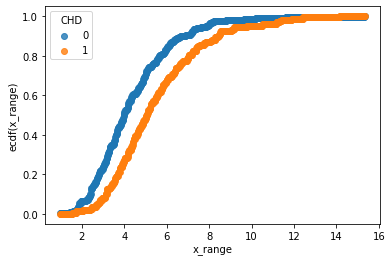

In [27]:
x_range = np.linspace(min(df['ldl']), max(df['ldl']), 1000)

for i in set(df['chd']):
    ecdf = ECDF(df[df['chd'] == i]['ldl'])
    sns.regplot(x=x_range, y=ecdf(x_range), fit_reg = False, label = i)
plt.xlabel('x_range')
plt.ylabel('ecdf(x_range)')
plt.legend(title='CHD');

### Now we get the statistics. In particular, we get the mean LDL difference between two groups and its confidence interval.

In [28]:
df0 = df[df['chd'] == 0]
df1 = df[df['chd'] == 1]
n0, n1 = len(df0), len(df1)

mu_0 = np.mean(df0['ldl'])
mu_1 = np.mean(df1['ldl'])
se_0 = np.std(df0['ldl']) / np.sqrt(n0)
se_1 = np.std(df1['ldl']) / np.sqrt(n1)

print('mu_0:', np.round(mu_0, 6))
print('mu_1:', np.round(mu_1, 6))
print('se_0:', se_0)
print('se_1:', se_1)

mu_0: 4.344238
mu_1: 5.487938
se_0: 0.1074535900297865
se_1: 0.17535689270552196


In [29]:
# Plug in estimator
T = mu_1 - mu_0
T_se = np.sqrt(se_0**2 + se_1**2)  

print('T:', T)
print('T_se:', T_se)

T: 1.1436990894039738
T_se: 0.2056606764299519


In [30]:
# 95% Interval
(T - 1.96*T_se, T + 1.96*T_se)

(0.7406041636012681, 1.5467940152066795)

## Bootstrap
Now we consider to get the distribution of median LDL for CHD=1

Median: 1.8050000000000002 



<AxesSubplot:ylabel='Count'>

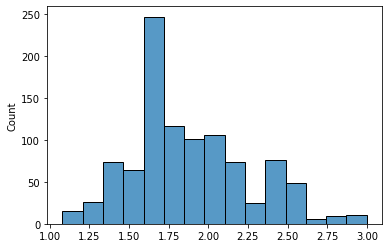

In [40]:

tobacco_1 = df1['tobacco']
T_Median = np.median(tobacco_1)
print("Median:", T_Median, "\n")

# Bootstrap

B = 1000
B_Median = np.zeros(B)

for i in range(B):
    B_sample = tobacco_1.sample(frac=1, replace = True)
    B_Median[i] = np.median(B_sample)
    
sns.histplot(x=B_Median, bins=15)


### Now we get various Bootstrap confidence intervals

In [32]:
def Get_CI(T, B_Sample):
    # Percentile Interval
    CI_Percent = list(np.quantile(B_Sample, q=[0.025, 0.975]))
    # Normal Interval
    se_b = np.std(B_Sample, ddof=1)
    CI_Normal = [T - 1.96*se_b, T + 1.96*se_b]
    # Pivot Interval
    CI_Pivot = [2*T - CI_Percent[1], 2*T - CI_Percent[0]]

    re = {'CI_Percent(2.5%, 97.5%)':CI_Percent, 'CI_Normal(2.5%, 97.5%)':CI_Normal, 'CI_Pivot(2.5%, 97.5%)':CI_Pivot}
    return re

Get_CI(T_Median, B_Median)

{'CI_Percent(2.5%, 97.5%)': [4.6850000000000005, 5.45],
 'CI_Normal(2.5%, 97.5%)': [4.723912567230286, 5.406087432769713],
 'CI_Pivot(2.5%, 97.5%)': [4.679999999999999, 5.4449999999999985]}

## LDL difference between CHD groups
Now we are interested in checking whether LDL levels are different by CHD groups. Here we use Bootstrap to get the confidence interval.

In [33]:
T_MeanDiff = np.mean(df1['ldl']) - np.mean(df0['ldl'])
print(T_MeanDiff)

1.1436990894039738


<AxesSubplot:ylabel='Count'>

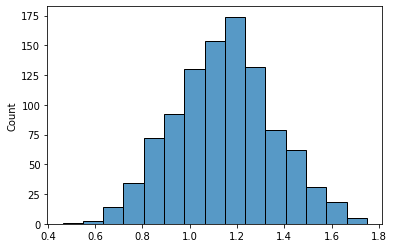

In [34]:
n = df.shape[0]
B = 1000
B_MeanDiff = np.zeros(B)

for i in range(B):
    B_sample_idx = np.random.choice(n, size=n, replace=True)
    df_B = df.iloc[B_sample_idx, ]
    mean1 = np.mean(df_B[df_B['chd'] == 1]['ldl'])
    mean0 = np.mean(df_B[df_B['chd'] == 0]['ldl'])
    B_MeanDiff[i] = mean1 - mean0
    
sns.histplot(x=B_MeanDiff, bins=15)

In [35]:
# Confidence Interval
Get_CI(T_MeanDiff, B_MeanDiff)

{'CI_Percent(2.5%, 97.5%)': [0.7497152072119176, 1.571462859398643],
 'CI_Normal(2.5%, 97.5%)': [0.7341319890531117, 1.5532661897548359],
 'CI_Pivot(2.5%, 97.5%)': [0.7159353194093045, 1.53768297159603]}

# Correlation between LDL and sbp
## Now researchers are interested in the correlation between LDL and sbp

0.2122465245650111

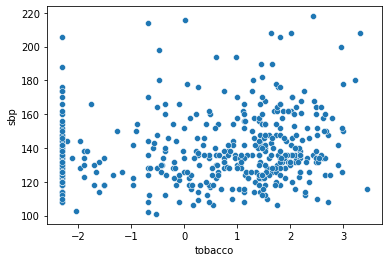

In [36]:
sns.scatterplot(x=np.log(df['tobacco']+0.1), y=df['sbp'])
T_Corr = np.corrcoef(df['tobacco'], df['sbp'])[0, 1]
T_Corr

<AxesSubplot:ylabel='Count'>

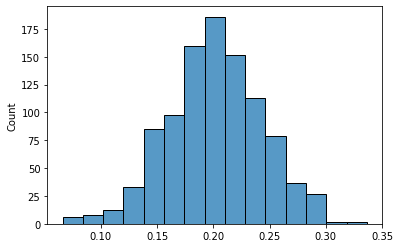

In [37]:
n = df.shape[0]
B = 1000
B_Corr = np.zeros(B)

for i in range(B):
    B_sample_idx = np.random.choice(n, size=n, replace=True)
    df1 = df.iloc[B_sample_idx, ]
    B_Corr[i] = np.corrcoef(np.log(df1['tobacco']+0.1), df1['sbp'])[0, 1]

sns.histplot(B_Corr, bins=15)

In [38]:
# Percentile Interval
Get_CI(T_Corr, B_Corr)

{'CI_Percent(2.5%, 97.5%)': [0.1196304602057621, 0.2860590168160485],
 'CI_Normal(2.5%, 97.5%)': [0.128845464220748, 0.29564758490927423],
 'CI_Pivot(2.5%, 97.5%)': [0.13843403231397372, 0.3048625889242601]}

In [39]:
# Use scipy.stats.bootstrap
#pip install -U scipy

import scipy.stats as st
def corr1(x1, y1):
    return np.corrcoef(x1,y1)[0,1]

x1 = df['tobacco']
y1 = df['sbp']

out = st.bootstrap((df['tobacco'],df['sbp']), corr1, paired=True, vectorized=False, method='BCa')

print(out)


AttributeError: module 'scipy.stats' has no attribute 'bootstrap'